# Developing an AI application

In this project, I'll train an image classifier to recognize different species of flowers. I'd train this classifier, then export it for use in application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



In [ ]:
# Imports here
import matplotlib.pyplot as plt
from PIL import Image
import json
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
import time



## Load the data

Here I'll use `torchvision` to load the data. The dataset is split into training, validation, and testing.

Training transformations:
random scaling, cropping, and flipping, resize to 224x224 pixels.

ImageNet dataset where each color channel was normalized separately. Normalize the means and standard deviations of the images to what the network expects for all three sets. These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Imageclassfier/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)


### Label mapping

load in a mapping from category label to category name in the file `cat_to_name.json`. This will give a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
with open('/content/drive/MyDrive/Imageclassfier/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier



* Load a pre-trained network
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters



In [ ]:
# Build and train your network
model = models.densenet121(pretrained=True)
model



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #training on GPU
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([("fc1",nn.Linear(1024, 512)),
                                 ("ReLU1",nn.ReLU()),
                                 ("dropout",nn.Dropout(0.5)),
                                 ("fc2",nn.Linear(512, 102)),
                                 ("output",nn.LogSoftmax(dim=1))]))
model.classifier = classifier
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.to(device)

epochs = 4
steps = 0
running_loss = 0
print_every = 10
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        #feed forward
        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        #backpropogation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    #feed forward and calculate loss
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
end_time = time.time()
print(f"Device = {device}")
print(f"Training time: {(end_time - start)//60}mins {(end_time - start)%60:.2f}seconds")

Epoch 1/4.. Train loss: 4.567.. Validation loss: 4.397.. Accuracy: 0.105
Epoch 1/4.. Train loss: 4.356.. Validation loss: 4.171.. Accuracy: 0.174
Epoch 1/4.. Train loss: 4.154.. Validation loss: 3.927.. Accuracy: 0.191
Epoch 1/4.. Train loss: 4.029.. Validation loss: 3.678.. Accuracy: 0.233
Epoch 1/4.. Train loss: 3.779.. Validation loss: 3.383.. Accuracy: 0.310
Epoch 1/4.. Train loss: 3.453.. Validation loss: 3.035.. Accuracy: 0.346
Epoch 1/4.. Train loss: 3.241.. Validation loss: 2.774.. Accuracy: 0.429
Epoch 1/4.. Train loss: 3.006.. Validation loss: 2.489.. Accuracy: 0.485
Epoch 1/4.. Train loss: 2.780.. Validation loss: 2.239.. Accuracy: 0.555
Epoch 1/4.. Train loss: 2.615.. Validation loss: 2.080.. Accuracy: 0.546
Epoch 2/4.. Train loss: 2.376.. Validation loss: 1.892.. Accuracy: 0.612
Epoch 2/4.. Train loss: 2.264.. Validation loss: 1.754.. Accuracy: 0.613
Epoch 2/4.. Train loss: 2.125.. Validation loss: 1.562.. Accuracy: 0.704
Epoch 2/4.. Train loss: 2.124.. Validation loss: 1.

## Testing network



In [ ]:
#  Do validation on the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()
start = time.time()
test_accuracy = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        ouputs = model(inputs)

        #calculate accuracy
        ps = torch.exp(ouputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(testloader):.3f}")

print(f"Device: {device}")
print(f"Testing time: {(time.time()-start)//60} mins {(time.time()-start)%60:.2f} seconds")

Test accuracy: 0.873
Device: cuda
Testing time: 5.0 mins 3.76 seconds


## Save the checkpoint



```model.class_to_idx = image_datasets['train'].class_to_idx```



In [ ]:
#  Save the checkpoint
model.class_to_idx = train_data.class_to_idx

checkpoint = {'input_size': 1024,
              'output_size': 102,
              'model' : model,
              'arch': 'densenet121',
              'batch_size': 64,
              'epochs': epochs,
              'learning_rate': 0.001,
              'classifier' : classifier,
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model.

In [ ]:
# Write a function that loads a checkpoint and rebuilds the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint('checkpoint.pth')
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Inference for classification



```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```



## Image Preprocessing



First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1.





In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    #  Process a PIL image for use in a PyTorch model
    wid = 256
    hei = 256
    if image.size[0] > image.size[1]:
        wid = image.size[0]
    else:
        hei = image.size[1]

    image.thumbnail((wid,hei))
    cropped1 = (256 - 224)/2
    cropped2 = (256 + 224)/2
    image = image.crop((cropped1, cropped1, cropped2, cropped2))
    image = np.array(image)
    image = image/255
    mean = np.array([0.485, 0.456, 0.406])
    stdv = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/stdv
    image = image.transpose(2, 0, 1)

    return image

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax



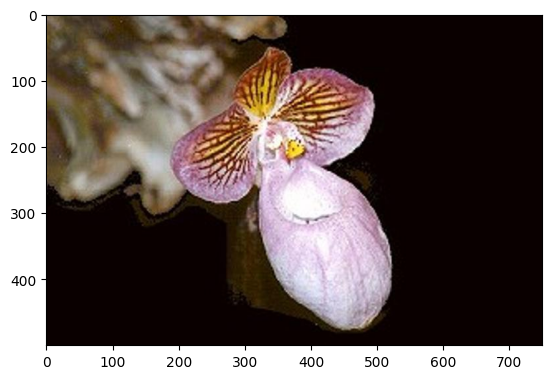

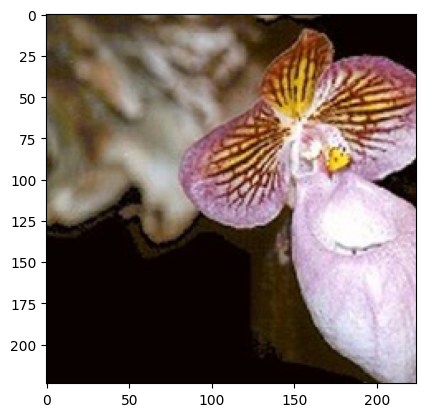

In [ ]:
image_path = '/content/drive/MyDrive/Imageclassfier/flowers/test/2/image_05125.jpg'
with Image.open(image_path) as image:
    plt.imshow(image)                #original
with Image.open(image_path) as image:
    imshow(process_image(image))     #processed

## Class Prediction

A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll  calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)` This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes.



```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #processing image
    image = Image.open(image_path)
    image = process_image(image)
    image = torch.from_numpy(image).float()
    image.unsqueeze_(0)
    image = Variable(image)


    C_I = model.class_to_idx
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model.forward(image)

    #get top K largest values
    ps = torch.exp(output)
    top_p, top_class = ps.topk(topk, dim=1)
    top_p = top_p.cpu().numpy()[0]
    I_C = {i: c for (c, i) in C_I.items()}
    top_classes = np.array([I_C[idx] for idx in top_class.cpu().numpy()[0]])

    return (top_p, top_classes)


In [ ]:
im_path = '/content/drive/MyDrive/Imageclassfier/flowers/test/2/image_05125.jpg'
probs, classes = predict(im_path, model)
print(probs)
print(classes)

[0.96605474 0.00715131 0.007066   0.00197568 0.00193816]
['2' '18' '52' '96' '84']


## Sanity Checking

Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.





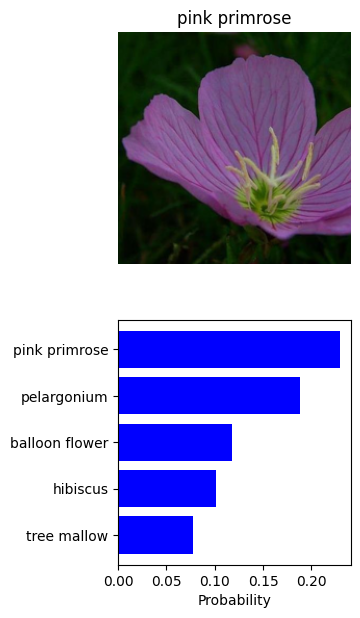

In [ ]:
#  Display an image along with the top 5 classes
im_path= '/content/drive/MyDrive/Imageclassfier/flowers/test/1/image_06752.jpg'  #pink primrose
image = process_image(Image.open(im_path))

probs, classes = predict(im_path, model)
max_prob = np.max(probs)
index = np.argwhere(probs == max_prob)
label = classes[index]

plt.figure(figsize=(3,7))
plt.subplot(2,1,1)
plt.axis('off')
plt.title(cat_to_name[label[0][0]])
img = imshow(image, ax = plt)

plt.subplot(2,1,2)
top_labels = [cat_to_name[i] for i in classes]
y = np.arange(len(classes))
plt.yticks(y, top_labels)
plt.xlabel('Probability')
plt.gca().invert_yaxis()
plt.barh(y, probs, align = 'center', color = 'blue')
plt.show()